# Convolutional Denoising Auto-Encoder

In this notebook, we will train a convolutional Denoising Auto-Encoder on MNIST dataset.
This example demonstrates the following features of `craynn` framework:
- loading data via dataflow and caching;
- construction of sequential models;
- training loop and mini-batches.

In [1]:
import numpy as np
import tensorflow as tf
from craynn import *

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

## Loading data

`craynn` is build to be orthogonal, so the data loading procedure is not important for the rest of the notebook.
However, we provide an option for an easy loading of some popular datasets, which is based on `craynn.datasets.dataflow` function.

`dataflow` accepts a sequence of `craynn.datasets.CachedComputations`, each of which, as name implies, try loading data from the cache before obtaining it from the original source.

Some `CachedComputations` like `craynn.datasets.download` are already predefined, others can be constructed by combining a loading function with a `craynn.datasets.meta.Cache` instance via `@` operator. Note, that this operator is a `__rmatmul__` method of the `Cache` class, therefore, loading function is not suppose to implement `__matmul__`.

In [2]:
data_train, _, data_test, _ = datasets.dataflow(
    datasets.download_mnist('MNIST/'),
    datasets.read_mnist @ datasets.pickled('MNIST/mnist.pickled')
)()

print(data_train.shape)
print(data_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


Again, orthogonal... The following code can be easily substituted by e.g. `tf.data.Dataset`.
Nevertheless, we find that maximal performance can be achived when dataset is loaded entirely into GPU memory.
For that, we have a special `craynn.updates.VariableDataset` class and constructor `craynn.variable_dataset`. The latter simply accepts data and stores it in a `tf.Variable` via the former.

`VariableDataset.batch(batch_size)` method returns a function (decorated with `tf.function`) that randomly selects `batch_size` elements from the original dataset.

Note, data in `VariableDataset` can be modified via `VariableDataset.assign`.

In [3]:
dataset = variable_dataset(data_train)
dataset_test = variable_dataset(data_test)

get_batch = dataset.batch(32)

## Defining model

There are at least two ways to define a model. The high-level method involves `craynn.network` function, which is a flexible way to define any directed acyclic graph (i.e. a network).

Convolutional AE is a sequential models, and such models can be defined by simply supplying `network` with the shape of the input and the sequence of layers. Some of the most popular layers are implemented under `craynn.layers`.

Notice a dense layer with an explicitly defined name.

In [4]:
nn = network((None, 1, 28, 28))(
    conv(8), conv(12), max_pool(),
    conv(16), conv(24), max_pool(),
    conv(32), global_max_pool(),
    dense(48, name='code'),
    dense(32),
    reshape((-1, 32, 1, 1)),
    upscale(), deconv(24),
    upscale(), deconv(16), deconv(12),
    upscale(), deconv(8), deconv(1, activation=linear()),
)

`craynn.viz` package provides several visualization tools (thanks to `graphviz`).

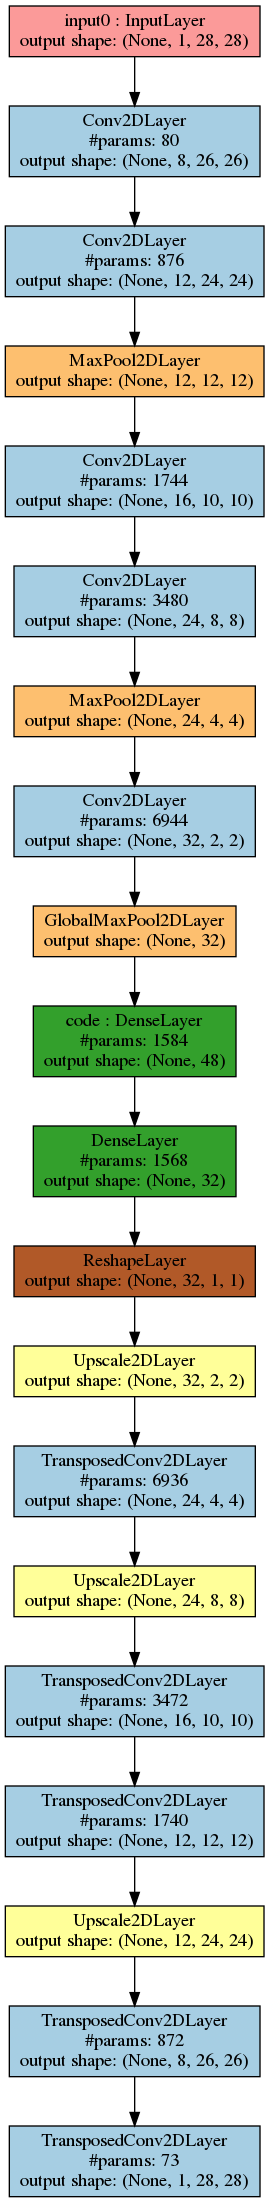

In [5]:
viz.draw_to_notebook(nn)

In [6]:
print(nn.description(short=True))

input0: (None, 1, 28, 28) -> (None, 1, 28, 28)
total number of params: 29369
input0 InputLayer (0 params): (None, 1, 28, 28)
Conv2DLayer (80 params): (None, 8, 26, 26)
Conv2DLayer (876 params): (None, 12, 24, 24)
MaxPool2DLayer (0 params): (None, 12, 12, 12)
Conv2DLayer (1744 params): (None, 16, 10, 10)
Conv2DLayer (3480 params): (None, 24, 8, 8)
MaxPool2DLayer (0 params): (None, 24, 4, 4)
Conv2DLayer (6944 params): (None, 32, 2, 2)
GlobalMaxPool2DLayer (0 params): (None, 32)
code DenseLayer (1584 params): (None, 48)
DenseLayer (1568 params): (None, 32)
ReshapeLayer (0 params): (None, 32, 1, 1)
Upscale2DLayer (0 params): (None, 32, 2, 2)
TransposedConv2DLayer (6936 params): (None, 24, 4, 4)
Upscale2DLayer (0 params): (None, 24, 8, 8)
TransposedConv2DLayer (3472 params): (None, 16, 10, 10)
TransposedConv2DLayer (1740 params): (None, 12, 12, 12)
Upscale2DLayer (0 params): (None, 12, 24, 24)
TransposedConv2DLayer (872 params): (None, 8, 26, 26)
TransposedConv2DLayer (73 params): (None, 1,

## Training

`craynn.updates` package (imported into `craynn`) provides an implementation of several popular optimization methods,
such as `SGD`, `RMSProp`, `adam` etc.

`tensorflow` has native operations for some optimizers such as `Adam`, which tend to consistently outperform `craynn.updates`. Wrappers over algorithms from `tf.keras.optimizers` can be found in `craynn.tf_updates`. With a few exceptions, authors advse to perfer `craynn.tf_updates` over `craynn.updates`.

All optimizers have a similar signature:
`optimizer(<hyper-parameters>)(target, variables) -> Optimizer`. An instance of optimizer is callable: `optimizer(*args)` performs a minization step of `target(*args)` w.r.t. `variables`.

`Optimizer.__call__` is decorated by `tf.function` therefore it is advised to make `target` argument-free, although, penalty for passing arguments is not significant.

In [7]:
def loss_f():
    X, = get_batch()
    noise = tf.random.normal(shape=tf.shape(X), stddev=0.2, dtype=tf.float32)
    reconstructed, = nn(X + noise)
    return tf.reduce_mean((X - reconstructed) ** 2)

In [8]:
opt = tf_updates.adam()(loss_f, nn.variables())

In [9]:
for _ in tqdm(range(32 * 1024)):
    opt()

### an alternative, slightly slower implementation
# loss_f = lambda X: tf.reduce_mean((X - nn(X)[0]) ** 2)
# opt = tf_updates.adam()(loss_f, nn.variables())
# for _ in tqdm(range(32 * 1024)):
#     opt(*get_batch())

## Linear algrebra in the code space

Sometimes (like in this example) it is convinent to operate with a part of the network as a separate network.
`Network.subnet` does exactly that.

Alternatively, one can simply define two separate networks.

Below we evaluate and visualize results of decoding linear combination of codes obtained from encoding some of the test samples.

In [10]:
### arguments default to the original network inputs/outputs.
encoder = nn.subnet(outputs=['code'])
decoder = nn.subnet(inputs=['code'])

In [11]:
n_pairs = 5
n_steps = 20

codes, = encoder(*dataset_test[:(2 * n_pairs)])

In [12]:
alphas = np.linspace(0, 1, num=n_steps)
codes = tf.reshape(codes, (n_pairs, 2, -1))

lincodes = alphas[:, None, None] * codes[:, 0, :] + (1 - alphas)[:,  None, None] * codes[:, 1, :]
lincodes = tf.reshape(lincodes, (n_steps * n_pairs, -1))

In [13]:
morphed = decoder(lincodes)[0].numpy().reshape((n_steps, n_pairs, 1, 28, 28))

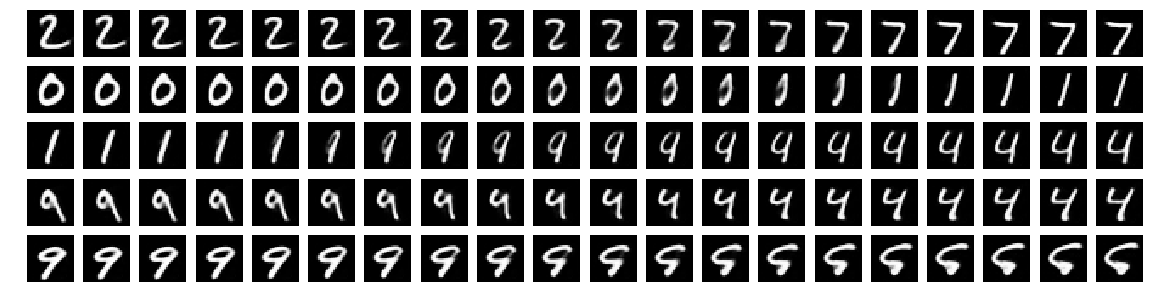

In [14]:
plt.subplots(n_pairs, n_steps, figsize=(n_steps, n_pairs))

for row_indx in range(n_pairs):
    for col_indx in range(n_steps):
        k = row_indx * n_steps + col_indx
        plt.subplot(n_pairs, n_steps, k + 1)
        plt.imshow(morphed[col_indx, row_indx, 0], vmin=0, vmax=1, cmap=plt.cm.Greys_r)
        plt.axis('off')

## A cheap-to-implement Markov chain

Bengio Y, Yao L, Alain G, Vincent P. Generalized denoising auto-encoders as generative models. In Advances in neural information processing systems 2013 (pp. 899-907).

In [15]:
n_samples = 10
n_steps = 16
skip = 16

X, = dataset_test[:n_samples]

results = np.ndarray(shape=(n_steps, ) + X.shape)

for i in tqdm(range(n_steps)):
    for _ in range(skip):
        X, = nn(X + tf.random.normal(shape=tf.shape(X), stddev=0.2))
    results[i] = X

Well, the actual method requires a more sophisticated training procedure, and, perhaps, a more powerful network.
Still, it is something...

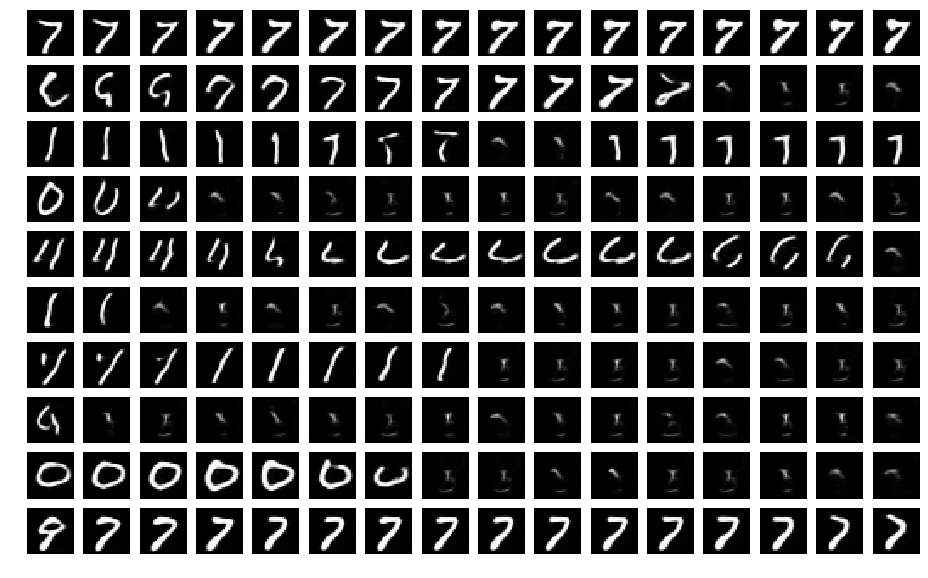

In [16]:
n_cols = n_steps
n_rows = n_samples

plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

for row_indx in range(n_rows):
    for col_indx in range(n_cols):
        k = row_indx * n_cols + col_indx
        
        plt.subplot(n_rows, n_cols, k + 1)
        plt.imshow(results[col_indx, row_indx, 0], vmin=0, vmax=1, cmap=plt.cm.Greys_r)
        plt.axis('off')

## Testing reconstruction quality (visually)

Just for fun.

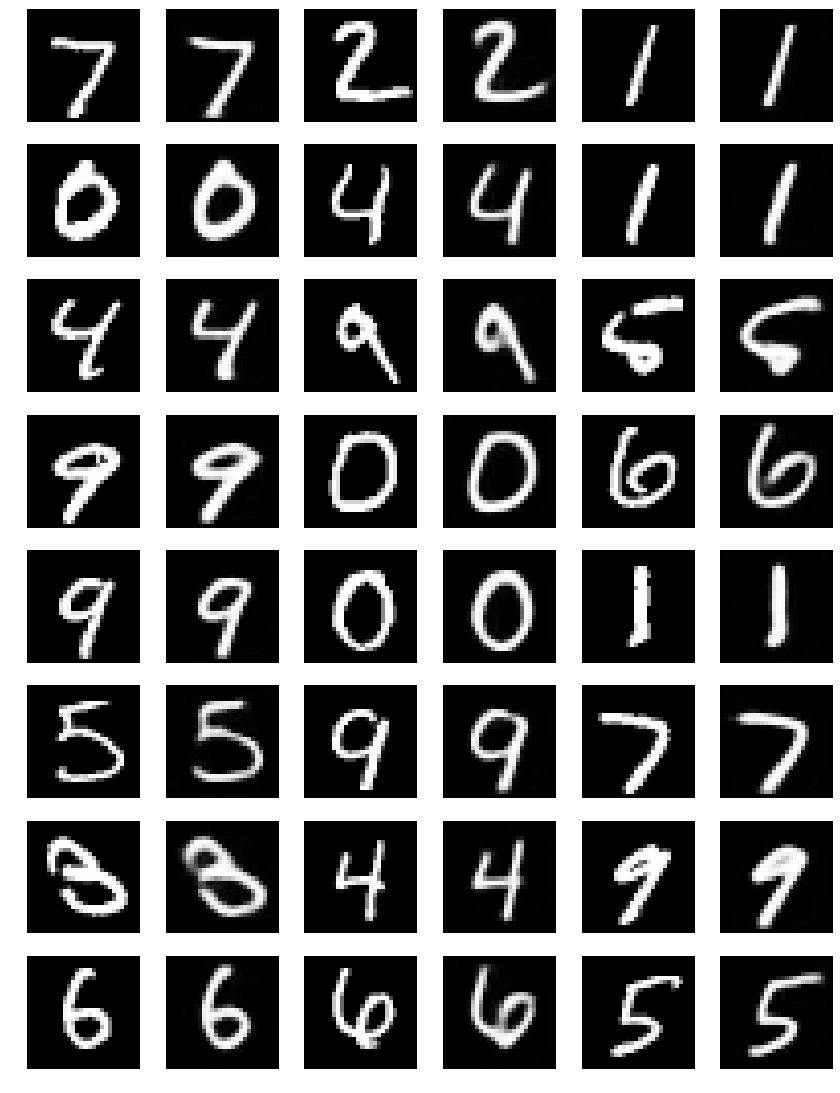

In [17]:
n_cols = 6
n_rows = 8

n = n_cols * n_rows // 2

img_test, = dataset_test[:n]
img_rec, = nn(*dataset_test[:n])

plt.subplots(n_rows, n_cols, figsize=(2.5 * n_cols - 0.5, 2.5 * n_rows- 0.5))

for i in range(n_cols):
    for j in range(n_rows // 2):
        k = i * n_rows // 2 + j
        plt.subplot(n_rows, n_cols, 2 * k + 1)
        plt.axis('off')
        plt.imshow(img_test[k, 0], cmap=plt.cm.Greys_r, vmin=0, vmax=1)
        
        plt.subplot(n_rows, n_cols, 2 * k + 2)
        plt.axis('off')
        plt.imshow(img_rec[k, 0], cmap=plt.cm.Greys_r, vmin=0, vmax=1)